In [1]:
from Dataset import Dataset

Using TensorFlow backend.


In [2]:
import numpy as np
import tensorflow as tf
import keras.layers as L
from keras.models import Sequential
from keras.optimizers import SGD
from keras.callbacks import *
from sklearn.model_selection import train_test_split

In [28]:
from IPython.display import clear_output
import matplotlib.pyplot as plt

class VisualizationCallback(Callback):
    def __init__(self, on_batch=False):
        Callback.__init__(self)
        self.on_batch = on_batch
    
    def visualize(self):
        clear_output(True)
        plt.figure(figsize=[12, 4])
        
        plt.subplot(1,2,1)
        plt.title("losses")
        plt.plot(self.loss_train, label='train loss')
        plt.plot(self.val_x, self.loss_val, label='val loss')
        plt.grid()
        plt.legend()

        plt.subplot(1,2,2)
        plt.title("accuracy")
        plt.plot(self.acc_train, label='train acc')
        plt.plot(self.val_x, self.acc_val, label='val acc')
        plt.grid()
        plt.legend()
        plt.show()
    
    def on_train_begin(self, logs={}):
        self.loss_train = []
        self.acc_train = []
        self.loss_val = []
        self.acc_val = []
        self.val_x = []

    def on_batch_end(self, batch, logs={}):
        if self.on_batch:
            self.loss_train.append(logs['loss'])
            self.acc_train.append(logs['acc'])
            if batch % 1000 == 0:
                self.visualize()
    
    def on_epoch_end(self, epoch, logs):
        self.loss_train.append(logs['loss'])
        self.acc_train.append(logs['acc'])
        if not self.on_batch:
            self.loss_val.append(logs['val_loss'])
            self.acc_val.append(logs['val_acc'])
            self.val_x.append(len(self.acc_train)-1)
            self.visualize()
        
        

In [29]:
# training framework for oracle net
class OracleNetTrainer(object):
    def __init__(self, test_size=0.1, autosave_path='./tmp/weights.{val_loss:.2f}.hdf5', vis_on_batch=False):
        """

        :param test_size: ratio of test (validation) set
        :param autosave_path: path to auto save training results
        :param vis_on_batch: whether to record visualization on batch
        """
        # load original data
        X_train, y_train = Dataset.load_data(num_cat=40, one_hot=False, filter_keys=['val'])
        X_val, y_val = Dataset.load_data(num_cat=40, one_hot=False, filter_keys=['val'], inclusive=True)
        # X, y = Dataset.load_data(one_hot=False, num_cat=40)
        # normalize image to 0.0 - 1.0
        self.X_train = X_train / 255
        self.X_val = X_val / 255
        # covert to different categories
        # y40 = Dataset.to_onehot(y, 40)
        # y = Dataset.cat40_to_cat10(y)
        # y10 = Dataset.to_onehot(y, 10)
        # train test split
        # idx = list(range(y40.shape[0]))
        self.y_train = {}
        self.y_val = {}
        self.y_train[40] = Dataset.to_onehot(y_train, 40)
        y_train = Dataset.cat40_to_cat10(y_train)
        self.y_train[10] = Dataset.to_onehot(y_train, 10)
        self.y_val[40] = Dataset.to_onehot(y_val, 40)
        y_val = Dataset.cat40_to_cat10(y_val)
        self.y_val[10] = Dataset.to_onehot(y_val, 10)
        # self.X_train, self.X_val, y_train_idx, y_val_idx = train_test_split(X, idx, test_size=test_size, shuffle=True)
        # self.y_train[40], self.y_val[40] = y40[y_train_idx], y40[y_val_idx]
        # self.y_train[10], self.y_val[10] = y10[y_train_idx], y10[y_val_idx]
        # initialize callbacks
#         self.checkpointer = ModelCheckpoint(filepath=autosave_path, verbose=1, save_best_only=True)
        self.visualizer = VisualizationCallback(vis_on_batch)

    def train(self, model, num_cat=10, batch_size=32, epochs=100, channels=0):
        assert num_cat in [10, 40], "Number of categories can only be 10 or 40"
        if channels == 0:
            model.fit(self.X_train, self.y_train[num_cat], batch_size=batch_size, epochs=epochs,
                      validation_data=(self.X_val, self.y_val[num_cat]),
                      callbacks=[self.visualizer], verbose=1, shuffle=True)
    #                   callbacks=[self.visualizer, self.checkpointer], verbose=1)
        else:
            model.fit(self.X_train.reshape(self.X_train.shape + (channels,)), self.y_train[num_cat], batch_size=batch_size, epochs=epochs,
                      validation_data=(self.X_val.reshape(self.X_val.shape + (channels,)), self.y_val[num_cat]),
                      callbacks=[self.visualizer], verbose=1, shuffle=True)
    #                   callbacks=[self.visualizer, self.checkpointer], verbose=1)

default_trainer = OracleNetTrainer()

### Simple Cat10

In [ ]:
def cat10_model_simple():
    model = Sequential()
    
#     model.add(L.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 1)))
#     model.add(L.Conv2D(32, (3, 3), activation='relu'))
#     model.add(L.MaxPooling2D(pool_size=(2, 2)))
# #     model.add(L.Dropout(0.25))

#     model.add(L.Conv2D(64, (3, 3), activation='relu'))
#     model.add(L.Conv2D(64, (3, 3), activation='relu'))
#     model.add(L.MaxPooling2D(pool_size=(2, 2)))
#     model.add(L.Dropout(0.25))
    
    model.add(L.Flatten(input_shape=(64,64)))
#     model.add(L.Flatten())
    model.add(L.Dense(64, activation='relu'))
    model.add(L.Dense(64, activation='relu'))
    model.add(L.Dense(10, activation='softmax'))
    
    return model

In [ ]:
model = cat10_model_simple()
model.summary()

In [ ]:
sgd = SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd,
              metrics=['accuracy'])

default_trainer.train(model)

## Simple Cat40

In [ ]:
def cat40_model_simple():
    model = Sequential()
    
    model.add(L.Flatten(input_shape=(64,64)))
    model.add(L.Dense(128, activation='relu'))
    model.add(L.Dense(128, activation='relu'))
    model.add(L.Dense(40, activation='softmax'))
    
    return model

In [ ]:
model = cat40_model_simple()
model.summary()

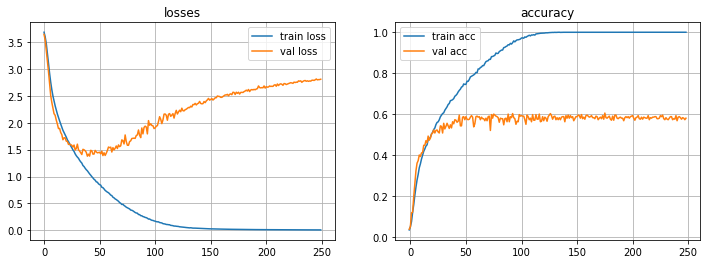

In [17]:
sgd = SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd,
              metrics=['accuracy'])

default_trainer.train(model, num_cat=40, epochs=100)

In [30]:
model.predict_classes(default_trainer.X_val.astype(np.float32))

TypeError: data type not understood

In [27]:
type(default_trainer.X_val)

numpy.ndarray

## Conv Cat40

In [30]:
def cat40_model_conv():
    model = Sequential()
    
    model.add(L.Conv2D(16, (3, 3), padding='same', activation='relu', input_shape=(64, 64, 1)))
    model.add(L.Conv2D(16, (3, 3), padding='same', activation='relu'))
    model.add(L.MaxPooling2D())
    
    model.add(L.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(64, 64, 1)))
    model.add(L.Conv2D(32, (3, 3), padding='same', activation='relu'))
    model.add(L.MaxPooling2D())
    
    model.add(L.Flatten())
    model.add(L.Dense(64, activation='relu'))
#     model.add(L.Dense(64, activation='relu'))
    model.add(L.Dense(40, activation='softmax'))
    
    return model

In [31]:
model = cat40_model_conv()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 64, 64, 16)        160       
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 64, 64, 16)        2320      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 32, 32, 32)        4640      
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 8192)              0         
__________

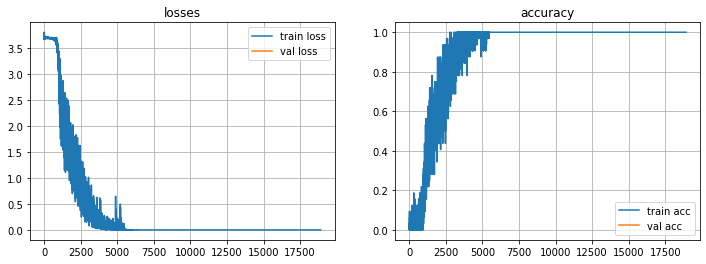

  64/6080 [..............................] - ETA: 1:14 - loss: 7.9042e-05 - acc: 1.0000

D:\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.429850). Check your callbacks.
  % delta_t_median)


6080/6080 [==============================] - 40s 7ms/step - loss: 8.1930e-05 - acc: 1.0000 - val_loss: 1.7718 - val_acc: 0.7500


In [32]:
sgd = SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd,
              metrics=['accuracy'])

conv_trainer = OracleNetTrainer(vis_on_batch=True)
conv_trainer.train(model, num_cat=40, epochs=100, channels=1)

In [33]:
from utils import *

In [38]:
y_pred = model.evaluate(conv_trainer.y_val, conv_trainer.X_val.reshape(conv_trainer.X_val.shape + (1,)))

ValueError: No data provided for "conv2d_16_input". Need data for each key in: ['conv2d_16_input']